In [1]:
import sys
import pandas as pd

sys.path.append('../utils')
from plot_functions import create_filter_plot, plot_categorical_bar_chart, plot_ratio_by_configurations

# Charger vos données
data = pd.read_excel("../DB/All-at-once_DB.xlsx", sheet_name='screen')

In [2]:
create_filter_plot(data)

Output()

In [3]:
particles = ['N']  # ['N', 'P']  
screens = ['Lead'] # ['Concrete', 'Steel', 'Water', 'Lead']
cases = ['C1 [U(4.95)O2F2 (H/235U = 410)]']  # ['C1 [U(4.95)O2F2 (H/235U = 410)]', 'C4 [U(93.2) (H/235U = 0)]']
codes = ['MCNP 6.1']  #  ['MCNP 6.1', 'COG 11.2', 'SCALE 6.2.2']
thicknesses = [] # [1, 5, 10, 20]

In [ ]:
particles = ['P']  # ['N', 'P']  
screens = ['Lead'] # ['Concrete', 'Steel', 'Water', 'Lead']
cases = ['C1 [U(4.95)O2F2 (H/235U = 410)]']  # ['C1 [U(4.95)O2F2 (H/235U = 410)]', 'C4 [U(93.2) (H/235U = 0)]']
codes = ['MCNP 6.1']  #  ['MCNP 6.1', 'COG 11.2', 'SCALE 6.2.2']
thicknesses = [5, 10, 20] # [1, 5, 10, 20]

In [4]:
plot_ratio_by_configurations(data, particles, screens, cases, codes, thicknesses)

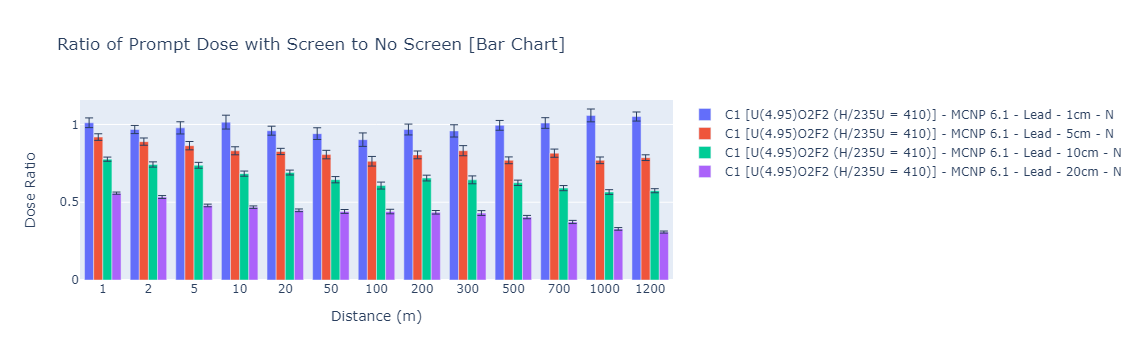

In [5]:
plot_categorical_bar_chart(data, particles, screens, cases, codes, thicknesses)

In [5]:
import plotly.express as px

print(px.colors.qualitative.Plotly)

['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']
